In [30]:
%reload_kedro --env=base

[02/22/24 18:02:29] INFO     Resolved project path as:                                              ]8;id=596143;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=972413;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/ipython/__init__.py#146\146]8;;\
                             /home/jamontanac/Documents/AdversarialExamples/adversarialexamples.                   
                             To set a different path, run '%reload_kedro <project_root>'                           

[02/22/24 18:02:30] INFO     Kedro project AdversarialExamples                                      ]8;id=488349;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=464075;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/ipython/__init__.py#115\115]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=299551;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=69724;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/ipython/__init__.py#116\116]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=308270;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=400224;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/ipython/__init__.py#122\122]8;;\

In [26]:
attacks_list=catalog.load("params:Adversarial_Attacks")

[02/22/24 18:01:00] INFO     Loading data from params:Adversarial_Attacks (MemoryDataset)...    ]8;id=119642;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=372450;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py#482\482]8;;\

In [39]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import art
from art.estimators.classification import PyTorchClassifier
from typing import Tuple, Dict, List
import importlib
import logging
from torch.utils.data import DataLoader

def create_loader(dataset,param_train):
    # Create a DataLoader
    loader = DataLoader(dataset, batch_size=param_train["batch_size"], shuffle=True,num_workers=param_train["num_workers"])
    return loader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def init_model(model:torch.nn.Module,lr:float=0.001)->Tuple[nn.Module,nn.Module,optim.Optimizer]:
    # Move model to GPU if available
    model = model.to(device)
    if device == 'cuda':
        model= torch.nn.DataParallel(model)
        cudnn.benchmark = True
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr,
                        momentum=0.9, weight_decay=5e-4)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
    return model, criterion, optimizer
def denormalize(tensor: torch.Tensor, mean= torch.tensor([0.4914, 0.4822, 0.4465], dtype=torch.float32), std =  torch.tensor([0.2023, 0.1994, 0.2010], dtype=torch.float32)):
    denorm = torch.clone(tensor)
    for t, m, s in zip(denorm, mean, std):
        t.mul_(s).add_(m)
    return denorm


def normalize(tensor: torch.Tensor, mean= torch.tensor([0.4914, 0.4822, 0.4465], dtype=torch.float32), std =  torch.tensor([0.2023, 0.1994, 0.2010], dtype=torch.float32)):
    norm = torch.clone(tensor)
    for t, m, s in zip(norm, mean, std):
        t.sub_(m).div_(s)
    return norm

def classification(model:nn.Module,parameters:Dict)-> art.estimators.classification.pytorch.PyTorchClassifier:
    model, criterion, optimizer = init_model(model)

    if device == "cuda":
        device_type = "gpu"
    else:
        device_type = "cpu"
    classes = parameters["classes"]
    input_shape = parameters["input_shape"]
    classifier = PyTorchClassifier(
        model=model,
        loss=criterion,
        optimizer=optimizer,
        nb_classes=classes,
        input_shape=input_shape,
        device_type=device_type,
    )
    return classifier

def Evasion_Attack(classifier:art.estimators.classification.pytorch.PyTorchClassifier,attack:Dict):
    attack_module = attack["module"]
    attack_type = attack["class"]
    attack_arguments = attack["kwargs"]
    
    attack_class=getattr(importlib.import_module(attack_module),attack_type)
    attack_instance = attack_class(classifier,**attack_arguments)


    return attack_instance

def Adversarial_generation(testloader:torch.utils.data.DataLoader,classifier: art.estimators.classification.pytorch.PyTorchClassifier, attack_params: Dict,test_data_information:Dict[str,List[float]])->Dict[str,torch.Tensor]:
    attack = Evasion_Attack(classifier,attack_params)
    logger = logging.getLogger(__name__)
    mean = test_data_information["mean"]
    std = test_data_information["std"]
    logger.info(f"Creating attack of type {type(attack)}")
    real_labels = []
    model_labels = []
    adversarial_examples = []
    adversarial_labels = []
    label_confidence = []
    adv_label_confidence = []
    for data in testloader:
        images, labels = data
        images_cpu = images.cpu().detach().numpy()
        x_test_adv = attack.generate(x=images_cpu,y=labels.cpu().numpy())
        with torch.no_grad():
            # perform inference
            label_prob = classifier.predict(images_cpu)
            adv_label_prob = classifier.predict(x_test_adv)
            
            # get confidence and labels for real data
            predictions = np.argmax(label_prob,axis=1)
            confidence_predictions = np.max(F.softmax(torch.tensor(label_prob),dim=1).cpu().numpy(),axis=1)
            
            # get confidence and labels for adversarial data
            adversarial_predictions = np.argmax(adv_label_prob,axis=1)
            confidence_predictions_adv = np.max(F.softmax(torch.tensor(adv_label_prob),dim=1).cpu().numpy(),axis=1)
            
        
        adversarial_denorm = [denormalize(torch.tensor(x),mean=mean, std = std) for x in x_test_adv]
        
        
        label_confidence.extend(confidence_predictions)
        adv_label_confidence.extend(confidence_predictions_adv)
        adversarial_examples.extend(adversarial_denorm)
        real_labels.extend(labels.cpu().numpy())
        model_labels.extend(predictions)
        adversarial_labels.extend(adversarial_predictions)
        break
        
    all_adversarial_examples = torch.stack(adversarial_examples)
    all_real_labels = torch.tensor(real_labels)
    all_model_labels = torch.tensor(model_labels)
    all_adversarial_labels = torch.tensor(adversarial_labels)
    all_confidence_labels = torch.tensor(label_confidence)
    all_adversarial_confidence_labels = torch.tensor(adv_label_confidence)
    
    adversarial_data = {
        "examples": all_adversarial_examples,
        "confidence": all_confidence_labels,
        "adversarial_confidence": all_adversarial_confidence_labels,
        "real_labels": all_real_labels,
        "model_labels": all_model_labels,
        "adversarial_labels": all_adversarial_labels,
    }

    old_accuracy = (all_real_labels == all_model_labels).sum().item()/ all_real_labels.size(0)
    new_accuracy =  (all_real_labels == all_adversarial_labels).sum().item()/ all_real_labels.size(0)
    logger.info(f"Accuracy of the model was {old_accuracy*100:.2f}% and now is {new_accuracy*100:.2f}%")
    return adversarial_data

# FSGM attack

[02/22/24 19:15:58] INFO     Loading data from Notebook_dataset (PytorchFlexibleDataset)...     ]8;id=206413;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=437196;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py#482\482]8;;\

[02/22/24 19:15:59] INFO     Loading data from params:Parameters_adversarial_generation         ]8;id=613281;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=880474;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py#482\482]8;;\
                             (MemoryDataset)...                                                                    

                    INFO     Loading data from Resnet_model (PytorchDatasetModel)...            ]8;id=917818;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=102220;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py#482\482]8;;\

                    INFO     Loading data from params:Data_information (MemoryDataset)...       ]8;id=713411;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=521190;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py#482\482]8;;\

                    INFO     Loading data from params:Data_information (MemoryDataset)...       ]8;id=730087;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=483192;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py#482\482]8;;\

                    WARNING  Clipping input data to the valid range for imshow with RGB data ([0..1]   ]8;id=209915;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/matplotlib/image.py\image.py]8;;\:]8;id=953702;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/matplotlib/image.py#701\701]8;;\
                             for floats or [0..255] for integers).                                                 

                    WARNING  Clipping input data to the valid range for imshow with RGB data ([0..1]   ]8;id=532276;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/matplotlib/image.py\image.py]8;;\:]8;id=578637;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/matplotlib/image.py#701\701]8;;\
                             for floats or [0..255] for integers).                                                 

                    WARNING  Clipping input data to the valid range for imshow with RGB data ([0..1]   ]8;id=825050;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/matplotlib/image.py\image.py]8;;\:]8;id=456633;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/matplotlib/image.py#701\701]8;;\
                             for floats or [0..255] for integers).                                                 

                    WARNING  Clipping input data to the valid range for imshow with RGB data ([0..1]   ]8;id=562282;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/matplotlib/image.py\image.py]8;;\:]8;id=130180;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/matplotlib/image.py#701\701]8;;\
                             for floats or [0..255] for integers).                                                 

                    WARNING  Clipping input data to the valid range for imshow with RGB data ([0..1]   ]8;id=622391;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/matplotlib/image.py\image.py]8;;\:]8;id=255586;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/matplotlib/image.py#701\701]8;;\
                             for floats or [0..255] for integers).                                                 

                    WARNING  Clipping input data to the valid range for imshow with RGB data ([0..1]   ]8;id=792528;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/matplotlib/image.py\image.py]8;;\:]8;id=888947;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/matplotlib/image.py#701\701]8;;\
                             for floats or [0..255] for integers).                                                 

                    WARNING  Clipping input data to the valid range for imshow with RGB data ([0..1]   ]8;id=155687;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/matplotlib/image.py\image.py]8;;\:]8;id=757667;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/matplotlib/image.py#701\701]8;;\
                             for floats or [0..255] for integers).                                                 

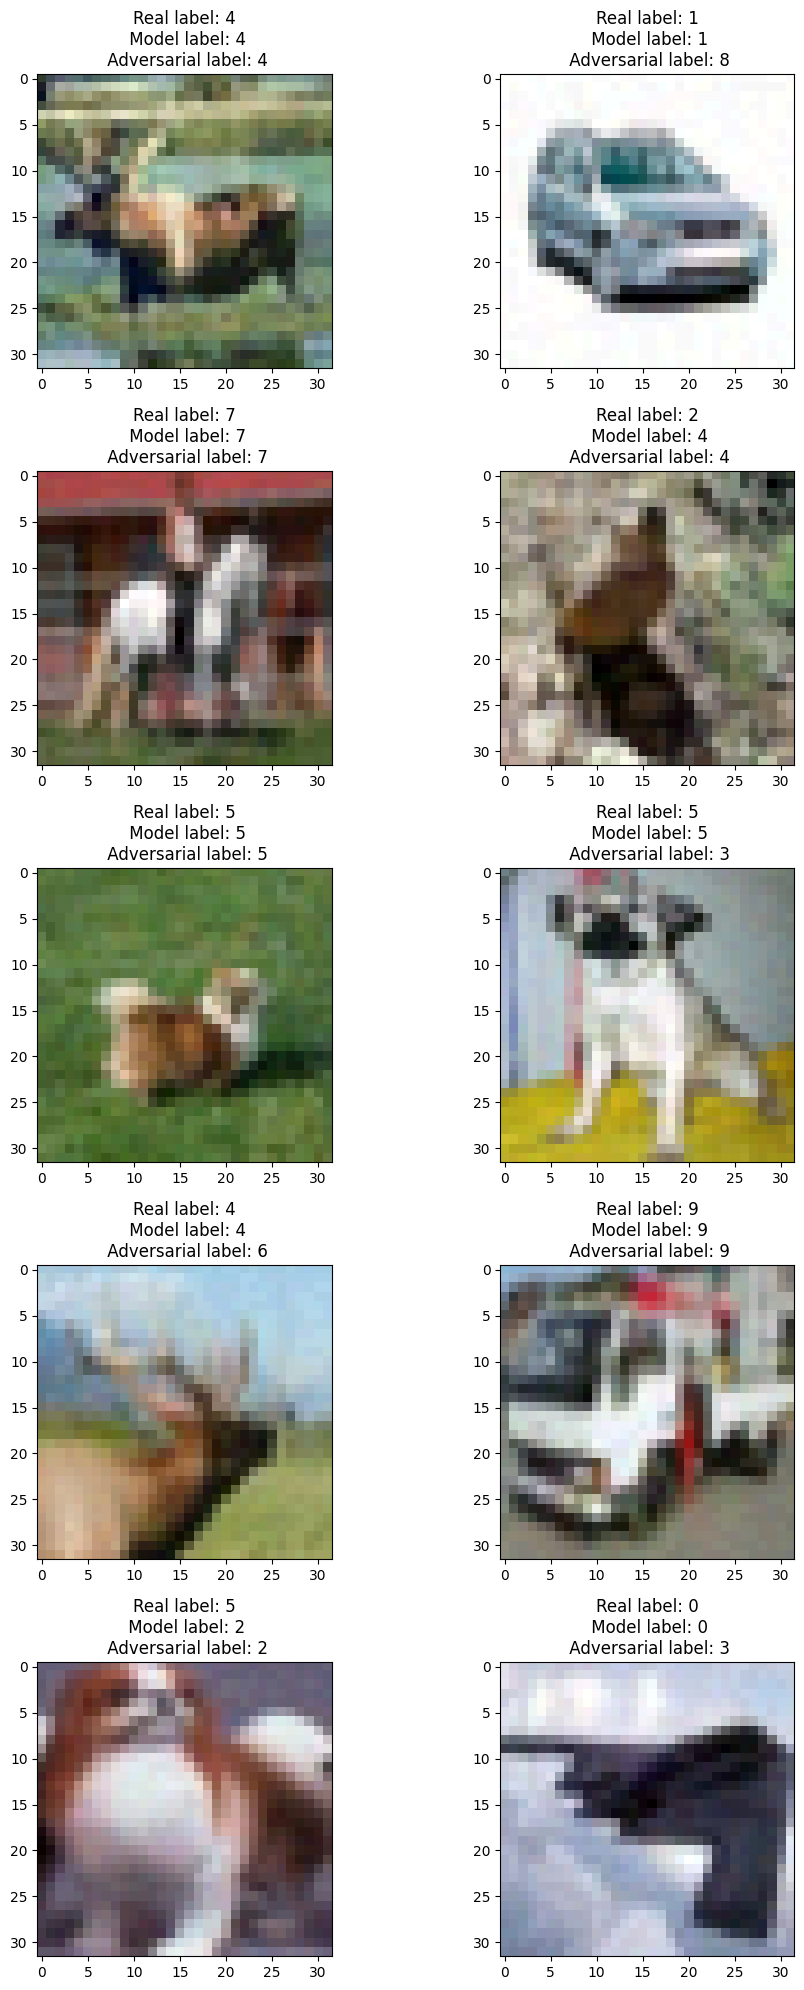

In [54]:

FSGM_attack ={
    'module': 'art.attacks.evasion',
    'class': 'FastGradientMethod',
    'kwargs': {'eps': 0.05, 'norm': 'inf', 'minimal': False, 'batch_size': 128, 'targeted': False}
}
adv_loader = create_loader(catalog.load('Notebook_dataset',),catalog.load("params:Parameters_adversarial_generation"))
model = catalog.load("Resnet_model")
classsifier = classification(model,catalog.load("params:Data_information"))
attack = Adversarial_generation(adv_loader,classsifier,FSGM_attack,catalog.load("params:Data_information"))

import matplotlib.pyplot as plt
to_visualize = 0
fig, axs = plt.subplots(5, 2, figsize=(10, 20))
for i in range(10):
    to_visualize = i
    row = i // 2
    col = i % 2
    axs[row, col].set_title(f"Real label: {attack['real_labels'][to_visualize]}\n Model label: {attack['model_labels'][to_visualize]}\n Adversarial label: {attack['adversarial_labels'][to_visualize]}")
    axs[row, col].imshow(attack['examples'][to_visualize].permute(1,2,0))
plt.tight_layout()
plt.show()


# PGD

[02/22/24 19:47:38] INFO     Loading data from Notebook_dataset (PytorchFlexibleDataset)...     ]8;id=936492;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=820561;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py#482\482]8;;\

[02/22/24 19:47:39] INFO     Loading data from params:Parameters_adversarial_generation         ]8;id=772751;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=730810;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py#482\482]8;;\
                             (MemoryDataset)...                                                                    

                    INFO     Loading data from Resnet_model (PytorchDatasetModel)...            ]8;id=885458;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=7180;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py#482\482]8;;\

                    INFO     Loading data from params:Data_information (MemoryDataset)...       ]8;id=183197;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=647337;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py#482\482]8;;\

                    INFO     Loading data from params:Data_information (MemoryDataset)...       ]8;id=61541;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=749305;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py#482\482]8;;\

                    WARNING  Clipping input data to the valid range for imshow with RGB data ([0..1]   ]8;id=605386;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/matplotlib/image.py\image.py]8;;\:]8;id=528704;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/matplotlib/image.py#701\701]8;;\
                             for floats or [0..255] for integers).                                                 

                    WARNING  Clipping input data to the valid range for imshow with RGB data ([0..1]   ]8;id=295595;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/matplotlib/image.py\image.py]8;;\:]8;id=521644;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/matplotlib/image.py#701\701]8;;\
                             for floats or [0..255] for integers).                                                 

                    WARNING  Clipping input data to the valid range for imshow with RGB data ([0..1]   ]8;id=389310;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/matplotlib/image.py\image.py]8;;\:]8;id=803390;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/matplotlib/image.py#701\701]8;;\
                             for floats or [0..255] for integers).                                                 

                    WARNING  Clipping input data to the valid range for imshow with RGB data ([0..1]   ]8;id=252550;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/matplotlib/image.py\image.py]8;;\:]8;id=254168;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/matplotlib/image.py#701\701]8;;\
                             for floats or [0..255] for integers).                                                 

                    WARNING  Clipping input data to the valid range for imshow with RGB data ([0..1]   ]8;id=938398;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/matplotlib/image.py\image.py]8;;\:]8;id=310253;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/matplotlib/image.py#701\701]8;;\
                             for floats or [0..255] for integers).                                                 

                    WARNING  Clipping input data to the valid range for imshow with RGB data ([0..1]   ]8;id=984952;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/matplotlib/image.py\image.py]8;;\:]8;id=313617;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/matplotlib/image.py#701\701]8;;\
                             for floats or [0..255] for integers).                                                 

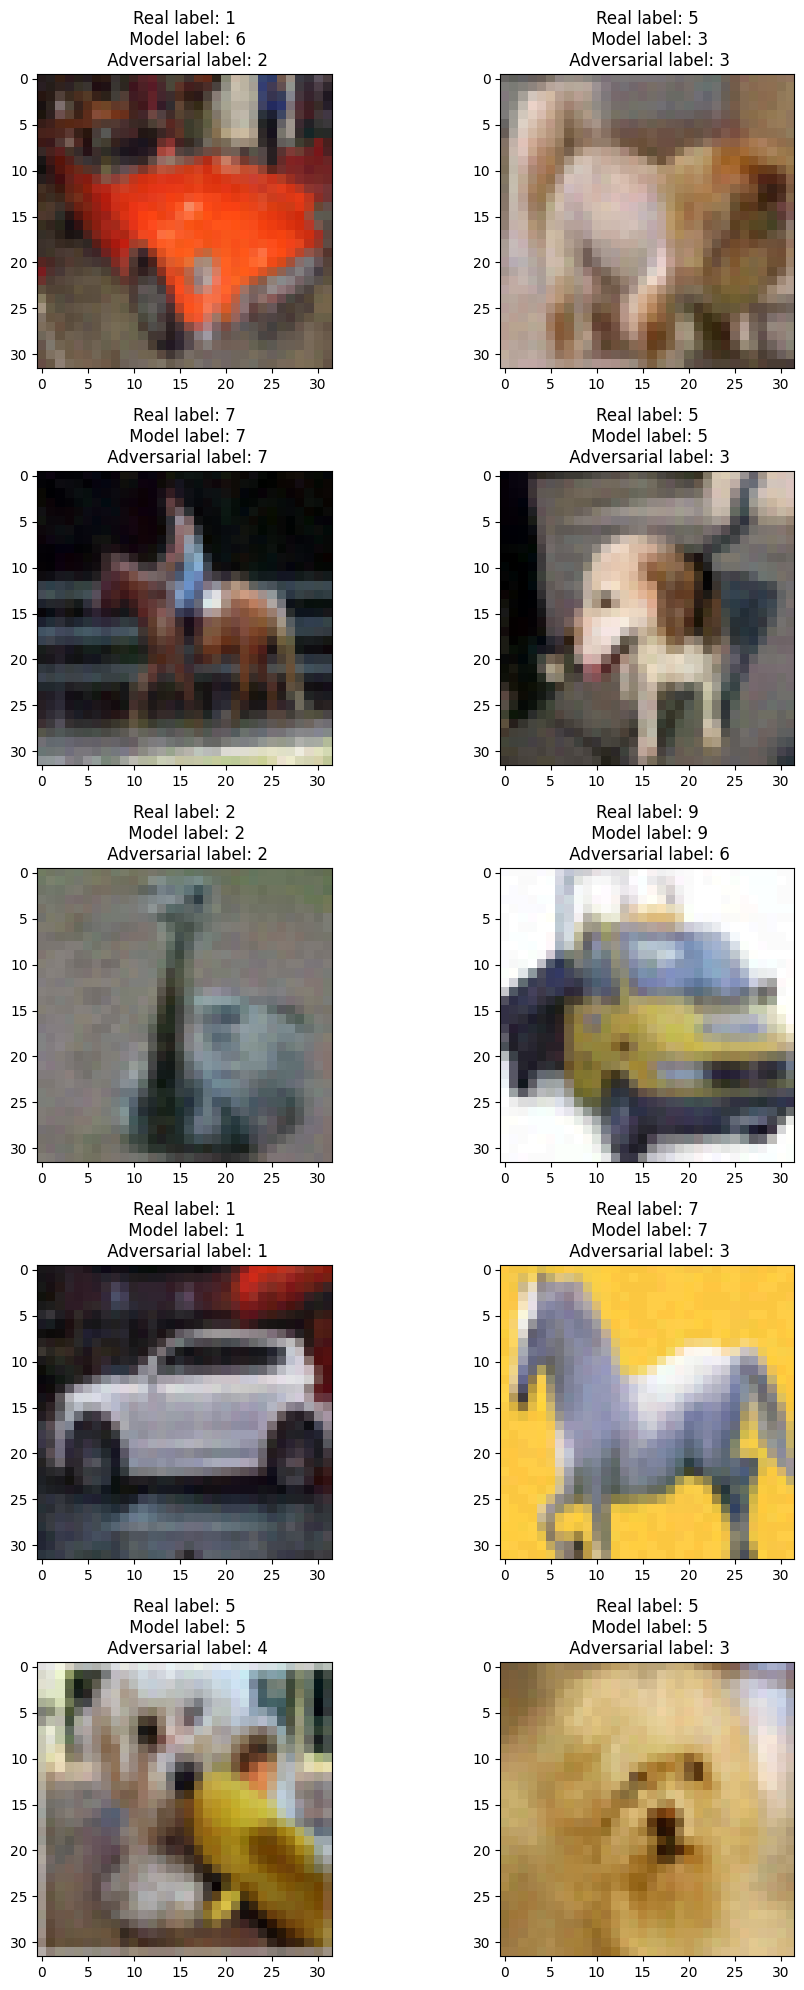

In [58]:


PGD_attack ={
    'module': 'art.attacks.evasion',
    'class': 'ProjectedGradientDescent',
    'kwargs':{  'eps': 0.1, 'eps_step': 0.001, 'max_iter': 10, 'batch_size': 256, 'num_random_init': 1 }
    
}
adv_loader = create_loader(catalog.load('Notebook_dataset',),catalog.load("params:Parameters_adversarial_generation"))
model = catalog.load("Resnet_model")
classsifier = classification(model,catalog.load("params:Data_information"))
attack = Adversarial_generation(adv_loader,classsifier,FSGM_attack,catalog.load("params:Data_information"))

import matplotlib.pyplot as plt
to_visualize = 0
fig, axs = plt.subplots(5, 2, figsize=(10, 20))
for i in range(10):
    to_visualize = i
    row = i // 2
    col = i % 2
    axs[row, col].set_title(f"Real label: {attack['real_labels'][to_visualize]}\n Model label: {attack['model_labels'][to_visualize]}\n Adversarial label: {attack['adversarial_labels'][to_visualize]}")
    axs[row, col].imshow(attack['examples'][to_visualize].permute(1,2,0))
plt.tight_layout()
plt.show()